In [1]:
import os
import glob  
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from Creator_dataset import Creator_dataset
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from os.path import isfile, join
from os import listdir
from pathlib import Path
from Creator_squares import Creator_squares
import shutil
import chess
import io
import json

In [2]:
def read_image(image_file):
        image = tf.io.read_file(image_file)
        image = tf.image.decode_image(image, channels=3, dtype=tf.float32)
        return image

def pred_to_piece(prediction):
    fen_posibilities = 'RNBQKPrnbqkp'
    pred_bool = list(prediction)
    return fen_posibilities[pred_bool.index(max(pred_bool))]

def get_all_imgs_in_folder(path):
    imgs = []
    for img_filename_found in glob.iglob(path+ '**/*.png', recursive=True):
        imgs.append(img_filename_found)
    return imgs

def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def board_to_fen(board):
    # Use StringIO to build string more efficiently than concatenating
    with io.StringIO() as s:
        for row in board:
            empty = 0
            for cell in row:
                c = cell[0]
                if c in ('w', 'b'):
                    if empty > 0:
                        s.write(str(empty))
                        empty = 0
                    s.write(cell[1].upper() if c == 'w' else cell[1].lower())
                else:
                    empty += 1
            if empty > 0:
                s.write(str(empty))
            s.write('/')
        # Move one position back to overwrite last '/'
        s.seek(s.tell() - 1)
        # If you do not have the additional information choose what to put
        s.write(' ' + str(turn) + ' KQkq - 0 1')
        return s.getvalue()

def import_label_demo(img_name):
    path = current_working_dir + "/03_demo_data/" + img_name + ".json"
    file_json = open(path)
    label = json.load(file_json)
    file_json.close()
    return label

In [3]:
# Step 1: Init
# Get the current working directory
creator_squares = Creator_squares() 
current_working_dir = os.getcwd().replace('\\','/')
path_img_dir_demo = current_working_dir + "/03_demo_data"
path_img_demo_squares = path_img_dir_demo + "/squares"
path_img_demo = get_all_imgs_in_folder(path_img_dir_demo)[0]
img_name_short = path_img_demo[-8:-4]

In [4]:
# Step 2: Create sqaures for demo
# Delet existing folder
if os.path.exists(path_img_demo_squares):
    shutil.rmtree(path_img_demo_squares)
# Create new squares
creator_squares.create_squares_single_img(path_img_demo)

--------------------
Starting: Creator Squares
 img_4633: done


In [5]:
# Step 3: Load model
model_occ = keras.models.load_model("models/CNN_occupancy")
model_piece = keras.models.load_model("models/TL_piece_classification")

In [6]:
# Step 4: Get img
# Foreach Chess Board Img
img_files = []
imgs = []
for img in glob.iglob(path_img_demo_squares + '**/*.png', recursive=True):
    img_files.append(img)

img_files.sort()
    
for img_path in img_files:
    img = read_image(img_path)
    imgs.append(img.numpy())
imgs = np.array(tuple(imgs))


In [7]:
# Step 5: Predict
pred_occ = model_occ.predict(imgs)
pred_occ = pred_occ.tolist()
pred_occ = [item for sublist in pred_occ for item in sublist]
pred_piece = model_piece.predict(imgs)
pred_piece_lit = [pred_to_piece(p) for p in pred_piece]

In [8]:
# Step 6: Turn
img_label = import_label_demo(img_name_short)
turn_white = img_label["white_turn"]
turn = "b"
if (turn_white):
    turn = "w"

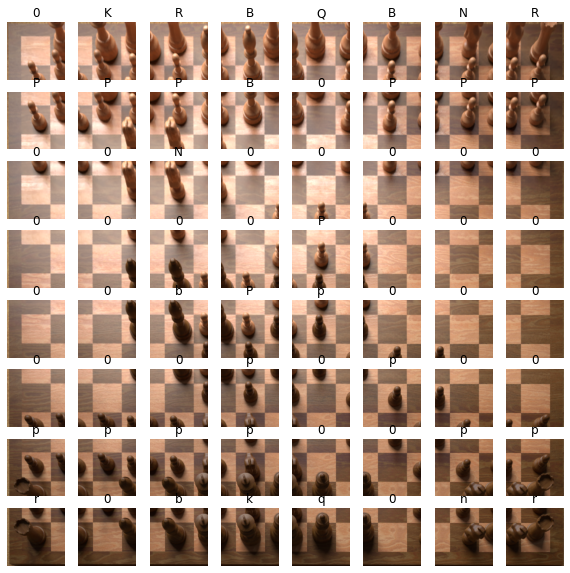

In [9]:
# Step 6: FEN creation
fen = []

for i in range(len(pred_occ)):
    if pred_occ[i] < 0.5:
        fen.append(0)
    else:
        fen.append(pred_piece_lit[i])



plt.figure(figsize=(10, 10))
for i in range(64):
  ax = plt.subplot(8, 8, i + 1)
  plt.imshow(imgs[i])
  plt.title(fen[i])
  plt.axis("off")
plt.show()


fen_trans = []

for f in fen:
    if f == 0:
        fen_trans.append("em")
    if f == "K":
        fen_trans.append("wk")
    if f == "k":
        fen_trans.append("bk")
    if f == "B":
        fen_trans.append("wb")
    if f == "b":
        fen_trans.append("bb")
    if f == "N":
        fen_trans.append("wn")
    if f == "n":
        fen_trans.append("bn")
    if f == "Q":
        fen_trans.append("wq")
    if f == "q":
        fen_trans.append("bq")
    if f == "P":
        fen_trans.append("wp")
    if f == "p":
        fen_trans.append("bp")
    if f == "R":
        fen_trans.append("wr")
    if f == "r":
        fen_trans.append("br")
    
fen_final = board_to_fen(list(split(fen_trans, 8)))

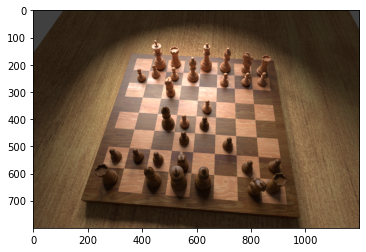

In [10]:
plt.imshow(read_image(path_img_demo))

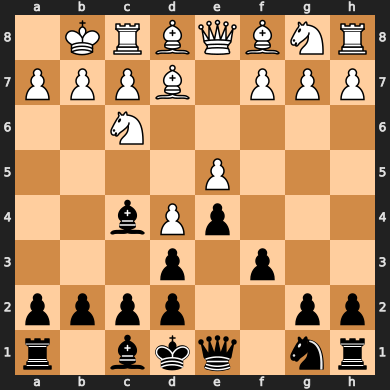

In [11]:
board = chess.Board(fen_final)
board

In [12]:
fen_final

'1KRBQBNR/PPPB1PPP/2N5/4P3/2bPp3/3p1p2/pppp2pp/r1bkq1nr b KQkq - 0 1'